In [1]:
import os
import sys
import scipy
import numpy as np
import cv2
from PIL import Image
import moviepy.editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage
from scipy import stats
from matplotlib import pyplot as plt, rcParams, rc
from sklearn import decomposition
from skimage.transform import resize

%matplotlib inline
%precision 4
%config InlineBackend.figure_format = 'retina'

rc('animation', html='html5')
rcParams['figure.figsize'] = 8, 10
np.set_printoptions(precision=4, linewidth=100)

In [10]:
# load the videos
video = mpy.VideoFileClip('C:/Users/Dell/Desktop/IIMB/data/video/Video_003.avi')


In [11]:
video.ipython_display(maxduration=200, width=300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [12]:
video.duration, video.size, video.fps

(113.5700, [320, 240], 7.0000)

In [30]:
# def create_data_matrix_from_video(clip, k=5, scale=50):
#     return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), 
#                       scale).flatten() for i in range(k * int(clip.duration))]).T

# def create_data_matrix_from_video(clip, k=5, dims=(60,80)):
#     return np.vstack([np.array(Image.fromarray(rgb2grey(video.get_frame(i/float(k))).astype(int)).resize(size=dims)).flatten() for i in range(k * int(clip.duration))]).T


# def create_data_matrix_from_video(clip, k, dims):
#     frames = []
#     for i in range(k * int(clip.duration)):
#         frame = clip.get_frame(i / float(k))
#         frame=cv2.resize(frame, dims)
#         frame = rgb2grey(frame).astype(int)
#         frame=frame.flatten()
#         frames.append(frame)
#     return np.vstack(frames).T # stack images horizontally

def rgb_gray(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def create_data_matrix_from_video(clip, k=5, dims=(80,60)):
    return np.vstack([resize(rgb_gray(clip.get_frame(i/float(k))).astype(int), 
                      dims).flatten() for i in range(k * int(clip.duration))]).T


def rgb2grey(rgb):
    return np.dot(rgb[..., :3], [0.299, 0.587, 0.114])

def plot_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f


In [50]:
# # change resolution of image
# scale =20    # scale to X percent (100 means no scaling). CHANGE THIS FOR BETTER RESOLUTION
# original_width = video.size[0]
# original_height = video.size[1]

# dims = (int(original_height * scale / 100), int(original_width * scale / 100))
# dims # single frame dimensions (height x width)

(64, 48)

In [ ]:
scale = 100   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [51]:
fps = 10
#M = create_data_matrix_from_video(video, fps, scale)
M = create_data_matrix_from_video(video, fps, dims)
M.shape, dims

((3072, 1130), (64, 48))

In [52]:
M

array([[145, 145, 145, ..., 146, 146, 146],
       [148, 148, 148, ..., 150, 150, 150],
       [152, 152, 152, ..., 155, 155, 155],
       ...,
       [ 74,  74,  74, ...,  76,  76,  76],
       [ 73,  73,  73, ...,  75,  75,  75],
       [ 61,  61,  61, ...,  62,  62,  62]])

In [53]:
M[:,1]

array([145, 148, 152, ...,  74,  73,  61])

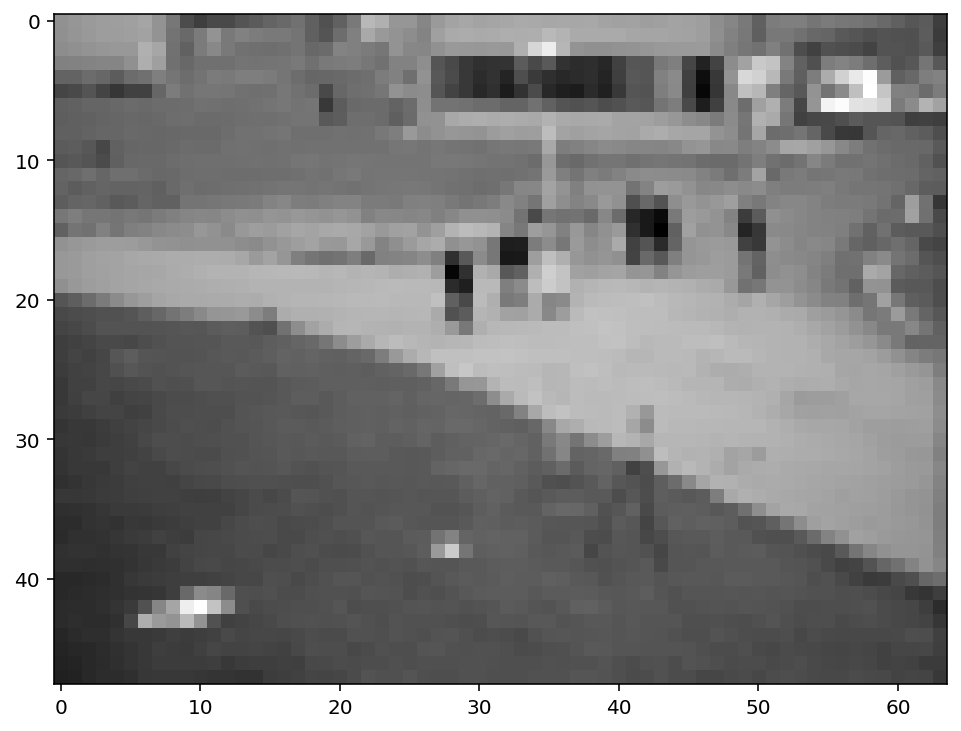

In [54]:
plt.imshow(np.reshape(M[:,140], (48, 64)), cmap='gray')

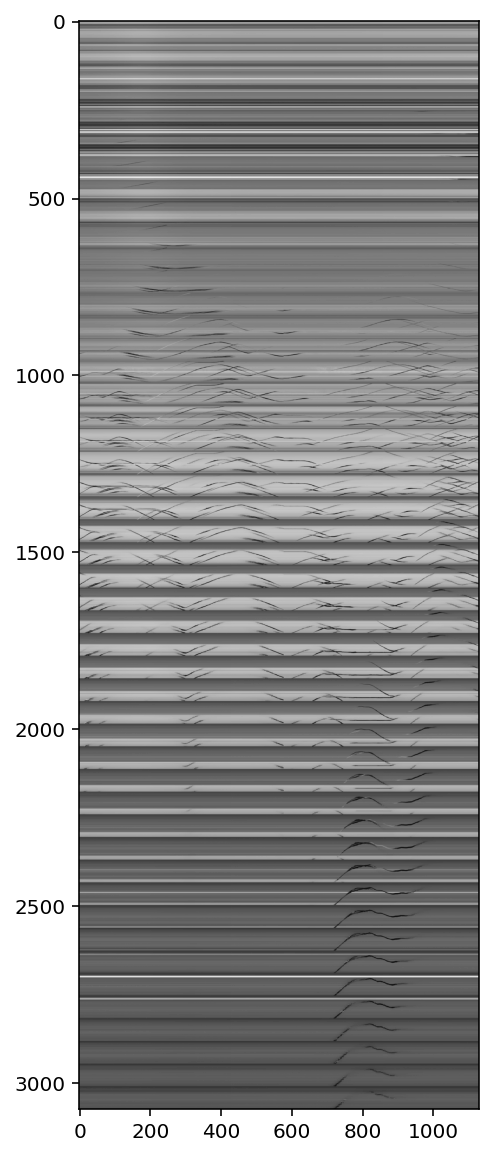

In [55]:
plt.imshow(M, cmap='gray')

In [56]:
random_columns = np.random.randint(0, M.shape[1], 1000)
background = stats.mode(M[:, random_columns], axis=1).mode
np.save('background', background)
background.shape

(3072, 1)

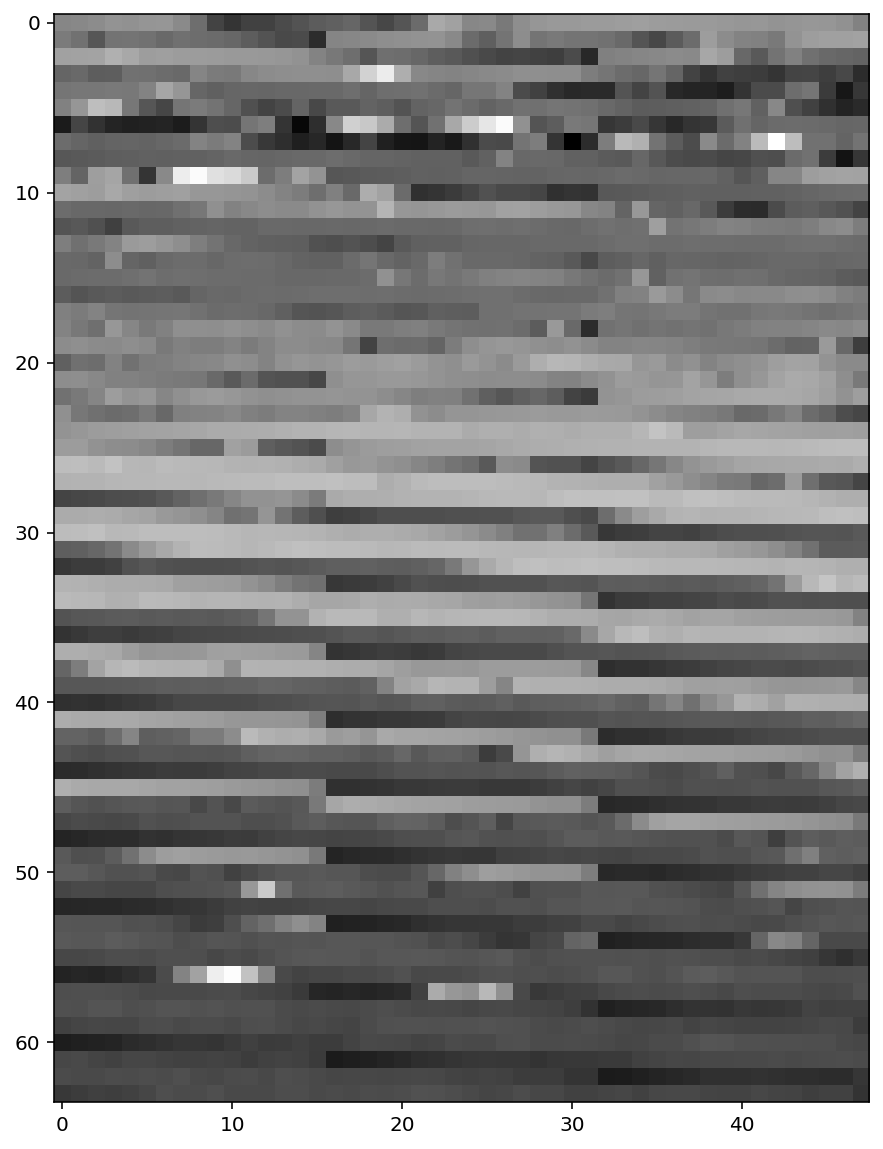

In [57]:
plt.imshow(background.reshape(dims), cmap='gray')

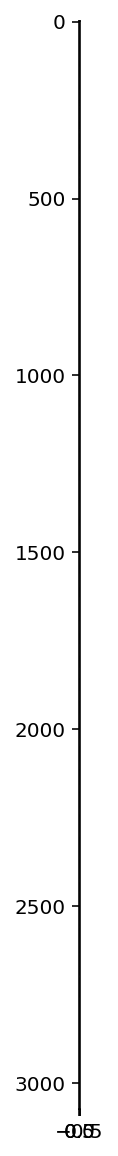

In [58]:
plt.imshow(background, cmap='gray')

In [59]:
people = M - background
people.shape


(3072, 1130)

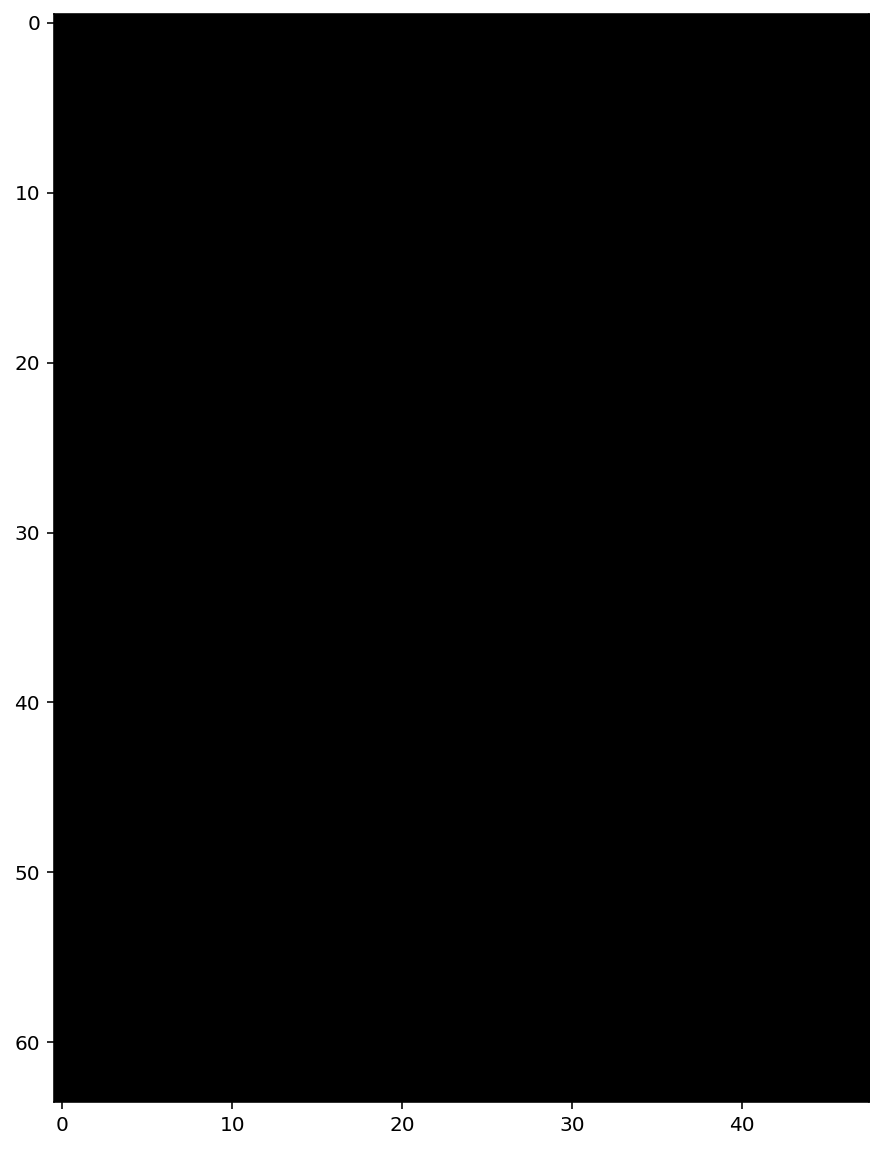

In [75]:
plt.imshow(people[:,140].reshape(64,48), cmap='gray')


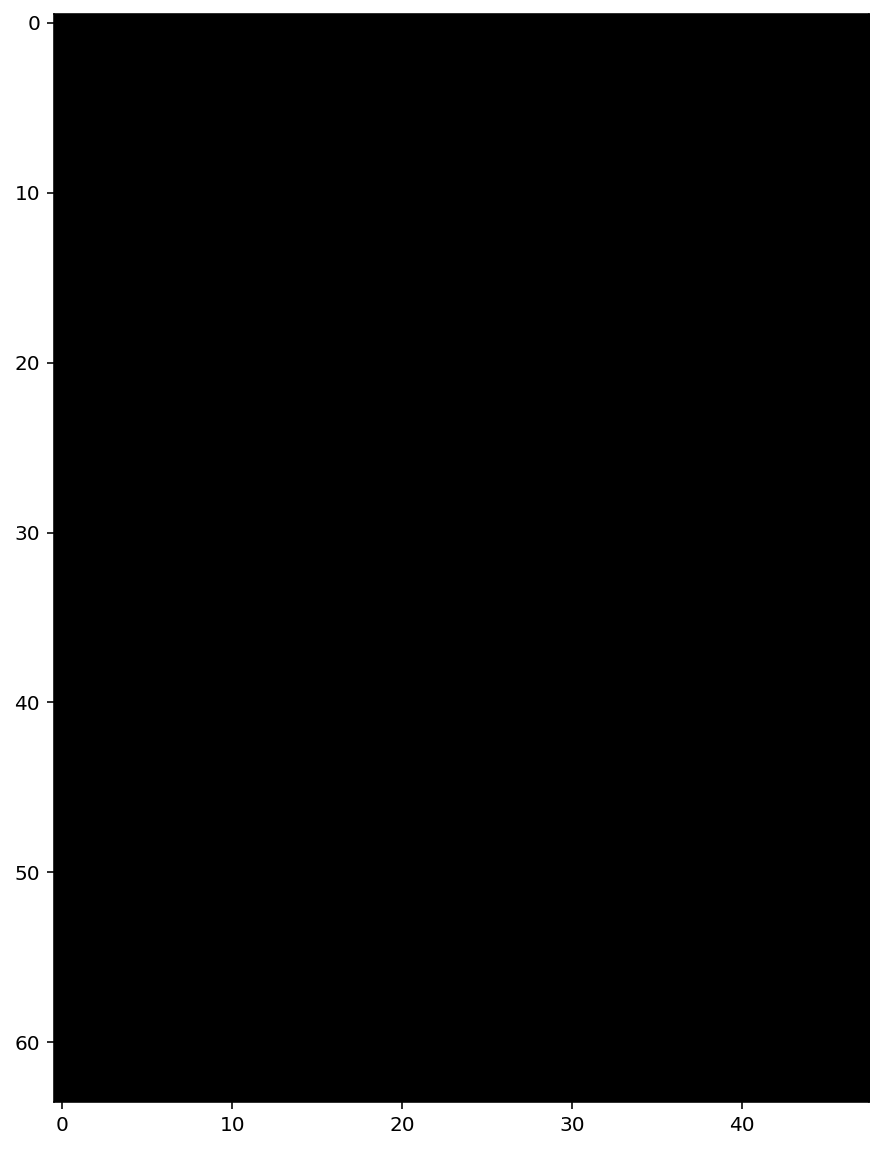

In [61]:
people[(people < 25) | (people > 210)] = 0
plt.imshow(people[:,140].reshape(dims), cmap='gray')

In [ ]:
z

In [62]:
from scipy import sparse
from sklearn.utils.extmath import randomized_svd
import fbpca

In [63]:
TOL=1e-9

In [64]:
def converged(Z, d_norm):
    err = np.linalg.norm(Z, 'fro') / d_norm
    print('error: ', err)
    return err < TOL

In [65]:
def shrink(M, tau):
    S = np.abs(M) - tau
    return np.sign(M) * np.where(S>0, S, 0)

In [66]:
def _svd(M, rank):
    return fbpca.pca(M, k=min(rank, np.min(M.shape)), raw=True)

In [67]:
def norm_op(M):
    return _svd(M, 1)[1][0]

In [68]:
def svd_reconstruct(M, rank, min_sv):
    u, s, v = _svd(M, rank)
    s -= min_sv
    nnz = (s > 0).sum()
    return u[:,:nnz] @ np.diag(s[:nnz]) @ v[:nnz], nnz

In [69]:
m, n = M.shape
round(m * .05)

154

In [70]:
def pcp(X, maxiter=10, k=10): # refactored
    m, n = X.shape
    trans = m<n
    if trans: X = X.T; m, n = X.shape
        
    lamda = 1.0 / np.sqrt(np.max(M.shape))
    op_norm = norm_op(X)
    Y = np.copy(X) / max(op_norm, np.linalg.norm( X, np.inf) / lamda)
    mu = k*1.25/op_norm; mu_bar = mu * 1e7; rho = k * 1.5
    
    d_norm = np.linalg.norm(X, 'fro')
    L = np.zeros_like(X); sv = 1
    
    examples = []
    
    for i in range(maxiter):
        print("rank sv:", sv)
        X2 = X + Y/mu
        
        # update estimate of Sparse Matrix by "shrinking/truncating": original - low-rank
        S = shrink(X2 - L, lamda/mu)
        
        # update estimate of Low-rank Matrix by doing truncated SVD of rank sv & reconstructing.
        # count of singular values > 1/mu is returned as svp
        L, svp = svd_reconstruct(X2 - S, sv, 1/mu)
        
        # If svp < sv, you are already calculating enough singular values.
        # If not, add 20% (in this case 240) to sv
        sv = svp + (1 if svp < sv else round(0.05*n))
        
        # residual
        Z = X - L - S
        Y += mu*Z; mu *= rho
        
        examples.extend([S[140,:], L[140,:]])
        
        if m > mu_bar: m = mu_bar
        if converged(Z, d_norm): break
    
    if trans: L=L.T; S=S.T
    return L, S, examples

In [71]:
L, S, examples =  pcp(M, maxiter=5, k=10)

rank sv: 1
error:  0.13443796556053034
rank sv: 57
error:  0.036514478340253086
rank sv: 27
error:  0.0035513514471887634
rank sv: 83
error:  0.00033039410636139416
rank sv: 139
error:  1.2743807354961168e-05


In [72]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

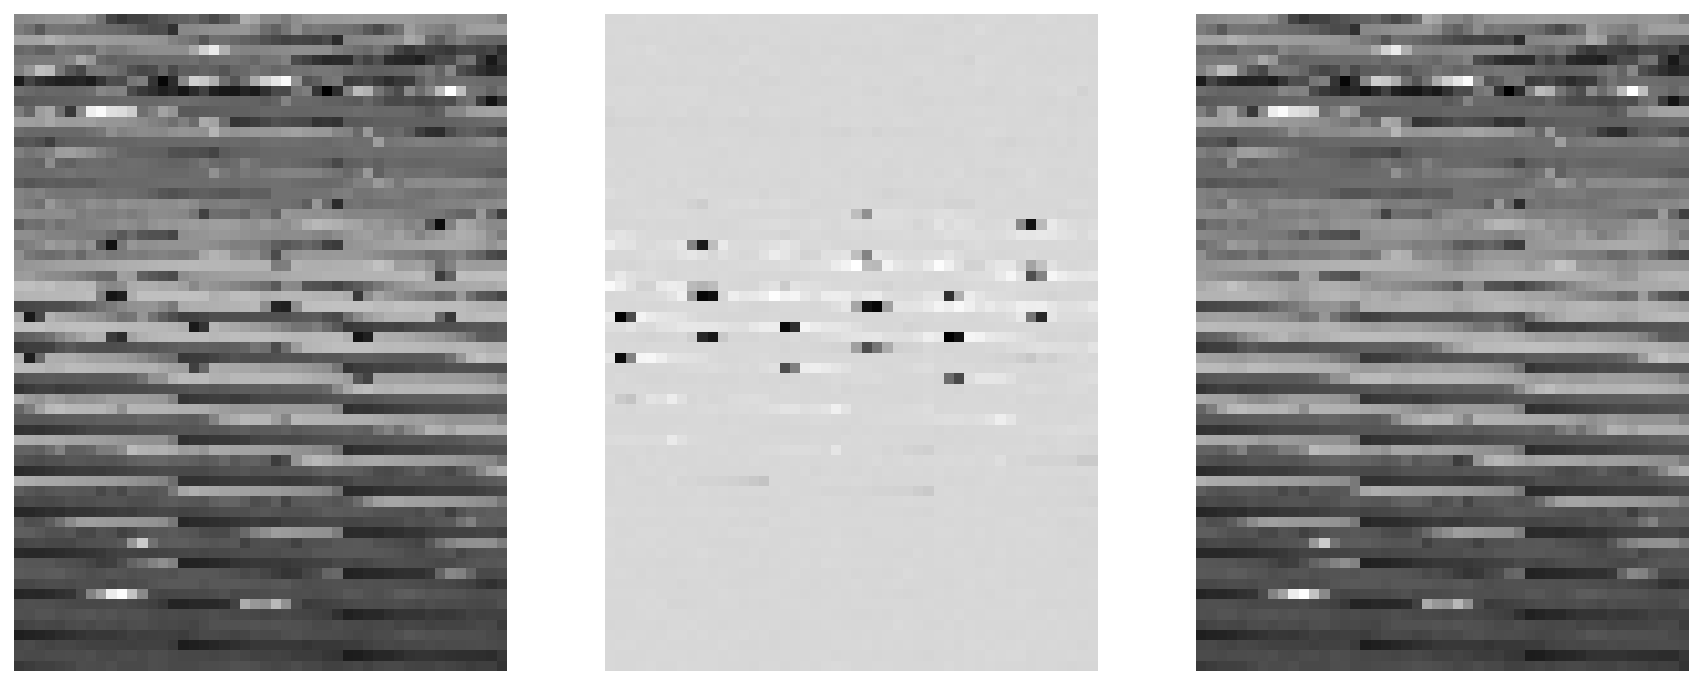

In [73]:
f = plt_images(M, S, L, [10], dims)

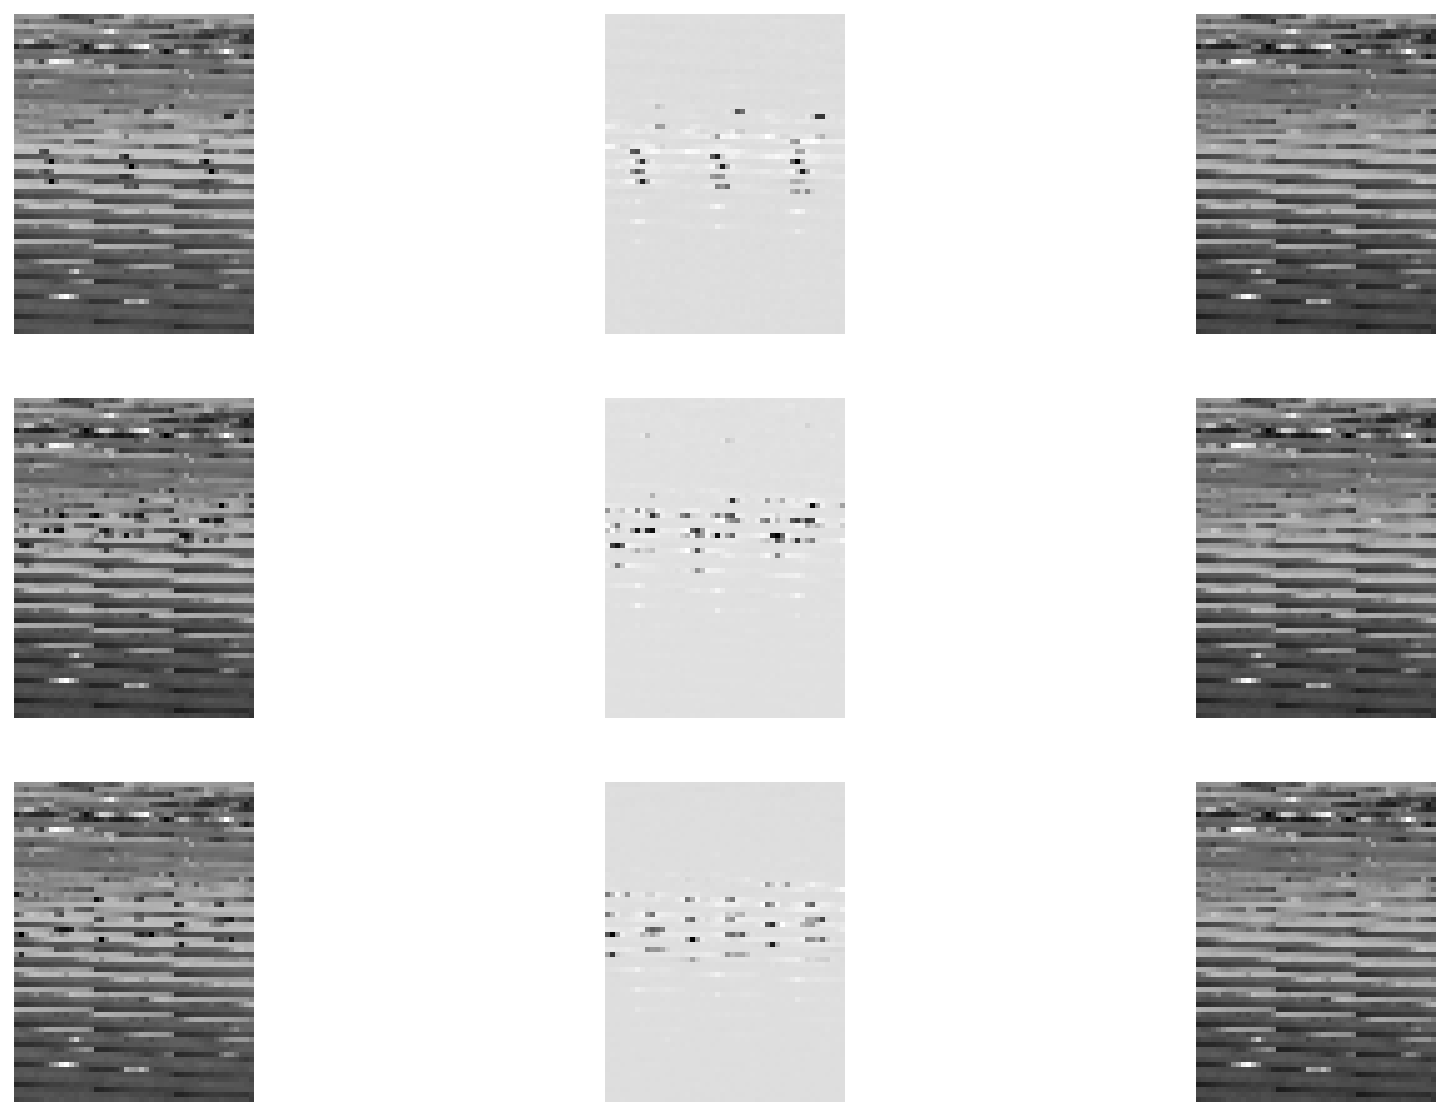

In [74]:
f = plt_images(M, S, L, [0, 100, 500], dims)

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(examples, cmap='gray')

In [ ]:
z

In [ ]:
people_frames = S.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('people1.mp4', fps=fps)

In [ ]:
AA1 = mpy.VideoFileClip('people1.mp4')
AA1.ipython_display(maxduration=200, width=300)

In [ ]:
background_frames = L.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('background_pcp.mp4', fps=fps)

In [ ]:
AA2 = mpy.VideoFileClip('background_pcp.mp4')
AA2.ipython_display(maxduration=200, width=300)

In [ ]:
original_frames = M.reshape((dims[0], dims[1], -1))

fig, ax = plt.subplots()
def make_frame(t):
    ax.clear()
    ax.imshow(people_frames[...,int(t*fps)])
    return mplfig_to_npimage(fig)

animation = mpy.VideoClip(make_frame, duration=int(video.duration-1))
animation.write_videofile('original_pcp.mp4', fps=fps)

In [ ]:
AA3 = mpy.VideoFileClip('original_pcp.mp4')
AA3.ipython_display(maxduration=200, width=300)

In [ ]:
display(M)
display(L)
display(S)

In [ ]:
from __future__ import division, print_function

__all__ = ["pcp"]

import time
import fbpca
import logging
import numpy as np
from scipy.sparse.linalg import svds


def pcp(M, delta=1e-7, mu=None, maxiter=500, verbose=False, missing_data=True,
        svd_method="approximate", **svd_args):
    # Check the SVD method.
    allowed_methods = ["approximate", "exact", "sparse"]
    if svd_method not in allowed_methods:
        raise ValueError("'svd_method' must be one of: {0}"
                         .format(allowed_methods))

    # Check for missing data.
    shape = M.shape
    if missing_data:
        missing = ~(np.isfinite(M))
        if np.any(missing):
            M = np.array(M)
            M[missing] = 0.0
    else:
        missing = np.zeros_like(M, dtype=bool)
        if not np.all(np.isfinite(M)):
            logging.warn("The matrix has non-finite entries. "
                         "SVD will probably fail.")

    # Initialize the tuning parameters.
    lam = 1.0 / np.sqrt(np.max(shape))
    if mu is None:
        mu = 0.25 * np.prod(shape) / np.sum(np.abs(M))
        if verbose:
            print("mu = {0}".format(mu))

    # Convergence criterion.
    norm = np.sum(M ** 2)

    # Iterate.
    i = 0
    rank = np.min(shape)
    S = np.zeros(shape)
    Y = np.zeros(shape)
    d_norm = np.linalg.norm(M, 'fro')
    while i < max(maxiter, 1):
        # SVD step.
        strt = time.time()
        u, s, v = _svd(svd_method, M - S + Y / mu, rank+1, 1./mu, **svd_args)
        svd_time = time.time() - strt

        s = shrink(s, 1./mu)
        rank = np.sum(s > 0.0)
        u, s, v = u[:, :rank], s[:rank], v[:rank, :]
        L = np.dot(u, np.dot(np.diag(s), v))

        # Shrinkage step.
        S = shrink(M - L + Y / mu, lam / mu)

        # Lagrange step.
        step = M - L - S
        step[missing] = 0.0
        Y += mu * step

        # Check for convergence.
        err = np.linalg.norm(step, 'fro') / d_norm
        if verbose:
            print(("Iteration {0}: error={1:.5e}, rank={2:d}, nnz={3:d}, "
                   "time={4:.3e}")
                  .format(i, err, np.sum(s > 0), np.sum(S > 0), svd_time))
        if converged(err, delta):
            break
        i += 1

    if i >= maxiter:
        logging.warn("convergence not reached in pcp")
    return L, S, (u, s, v)


def shrink(M, tau):
    sgn = np.sign(M)
    S = np.abs(M) - tau
    S[S < 0.0] = 0.0
    return sgn * S

def converged(err, delta):
    return err < delta

def _svd(method, X, rank, tol, **args):
    rank = min(rank, np.min(X.shape))
    if method == "approximate":
        return fbpca.pca(X, k=rank, raw=True, **args)
    elif method == "exact":
        return np.linalg.svd(X, full_matrices=False, **args)
    elif method == "sparse":
        if rank >= np.min(X.shape):
            return np.linalg.svd(X, full_matrices=False)
        u, s, v = svds(X, k=rank, tol=tol)
        u, s, v = u[:, ::-1], s[::-1], v[::-1, :]
        return u, s, v
    raise ValueError("invalid SVD method")

In [ ]:
L, S, (u, s, v) = pcp(M, maxiter=1000, verbose=True, svd_method="exact")